# Figures for Geological Model Discretization Paper

This notebook contains the code to generate Figure 1 and Figure 2a from our paper.  Doing it this way is faster when prototyping small visual adjustments to the figure, since changes to the figure can be made interactively based on data already in memory.

## Figure 1:  Effects of aliasing on gravity inversion posterior for spherical intrusion

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from blockworlds.gravity import profile_timer, DiscreteGravity
from blockworlds.gravity import baseline_tensor_mesh, survey_gridded_locations, analytic_forward_gravity_sphere

# Mesh properties
z0, L, NL = 0.0, 1000.0, 15
h = L/NL
print("z0, L, nL, h =", z0, L, NL, h)
mesh = baseline_tensor_mesh(NL, h, centering='CCN')
mesh_hires = baseline_tensor_mesh(NL*4, h/4, centering='CCN')
# Gravity survey properties
survey = survey_gridded_locations(L, L, 20, 20, z0)
# Properties of spherical inclusion
x0, y0, z0, R_0, rho_0 = 0.0, 0.0, -500.0, 300.0, 3.0
M = 4.0*np.pi/3.0 * rho_0 * R_0**3
rho2R = lambda rho: (0.75*M/(np.pi*rho))**(1/3.0)

z0, L, nL, h = 0.0 1000.0 15 66.66666666666667


In [2]:
from blockworlds.implicit import GeoHistory, BasementEvent, SphereIntrusionEvent
from blockworlds.implicit import UniGaussianDist, UniformDist, vMFDist

# Define the geology as a list of chained events
# I'm forcing us to use keyword arguments everywhere for readability
history = GeoHistory()
# Basement:  density (g/cc)
history.add_event(
    BasementEvent(
        [('density', UniGaussianDist(mean=2.0, std=0.5))]
    )
)
# Spherical intrusion:  center (x, y, z) (m), radius (m), density (g/cc)
history.add_event(
    SphereIntrusionEvent(
        [('x0', UniGaussianDist(mean=0.0, std=0.5)),
         ('y0', UniGaussianDist(mean=0.0, std=0.5)),
         ('z0', UniGaussianDist(mean=-500.0, std=0.5)),
         ('R', UniGaussianDist(mean=300.0, std=100.0)),
         ('density', UniGaussianDist(mean=3.0, std=1.0))]
    )
)

# Set the ground truth parameters
history.deserialize([0.0, x0, y0, z0, R_0, rho_0])
histpars = history.serialize()
print("history.serialize() =", histpars)
# Define the forward model
fwdmodel = DiscreteGravity(mesh, survey, history.event_list[0])
fwdmodel.gfunc = history.event_list[0].rockprops
fwdmodel.edgemask = profile_timer(fwdmodel.calc_gravity, h)
fwdmodel.gfunc = history.event_list[-1].rockprops
# Define a second, hi-res forward model
fwdmodel_hires = DiscreteGravity(mesh_hires, survey, history.event_list[0])
fwdmodel_hires.gfunc = history.event_list[0].rockprops
fwdmodel_hires.edgemask = profile_timer(fwdmodel_hires.calc_gravity, h/4)
fwdmodel_hires.gfunc = history.event_list[-1].rockprops

history.serialize() = [   0.    0.    0. -500.  300.    3.]
calc_gravity ran in 0.875 sec
calc_gravity ran in 44.341 sec


calc_gravity ran in 0.004 sec
calc_gravity ran in 0.064 sec


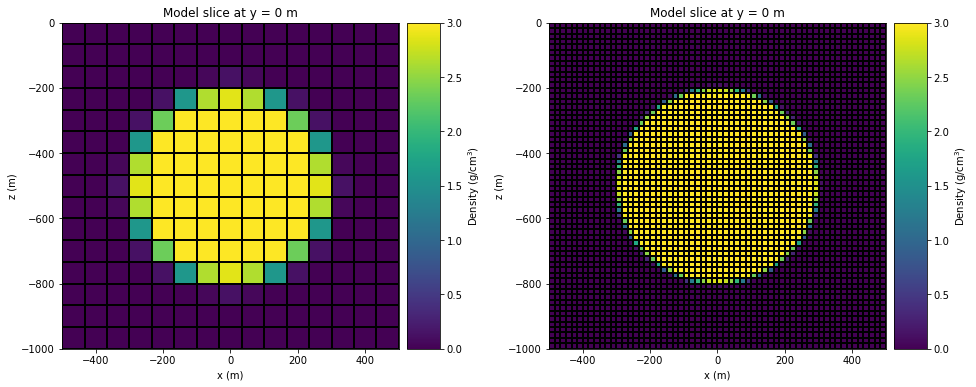

In [3]:
# Calculate and plot voxels
profile_timer(fwdmodel.calc_gravity, h)
profile_timer(fwdmodel_hires.calc_gravity, h/4)
fwdmodel.fwd_data -= fwdmodel.edgemask * fwdmodel.voxmodel.mean()
fig = plt.figure(figsize=(16,6))
ax = plt.subplot(1, 2, 1)
fwdmodel.plot_model_slice(ax=ax)
ax = plt.subplot(1, 2, 2)
fwdmodel_hires.plot_model_slice(ax=ax)
plt.show()

In [4]:
from riemann import Sampler, Model
from riemann.proposals.randomwalk import AdaptiveMetropolisRandomWalk as AMRW

class GeoModel(Model):
    
    def __init__(self, history, fwdmodel, dsynth, sigdata):
        # Set baseline attributes
        self.history = history
        self.dsynth = dsynth
        self.sigdata = sigdata
        self.liketype = 'gaussian'
        # Set forward model to represent history
        self.set_fwdmodel(fwdmodel)
        
    def set_fwdmodel(self, fwdmodel):
        self.fwdmodel = fwdmodel
        self.fwdmodel.gfunc = history.rockprops
        mesh = self.fwdmodel.mesh
        # Turn full anti-aliasing on by default; match h to grid resolution
        self.h = np.exp(np.mean(np.log([mesh.hx, mesh.hy, mesh.hz])))
        
    def set_liketype(self, liketype):
        if liketype not in ('iiG', 'L2G', 'iiC', 'L2C'):
            raise NotImplementedError
        self.liketype = liketype
        
    def log_likelihood(self, theta):
        # Load this parameter vector into the history and calculate gravity
        self.history.deserialize(theta)
        dpred = self.fwdmodel.calc_gravity(self.h)
        resids = dpred - self.dsynth
        resids = resids - resids.mean()
        Rs = resids/self.sigdata
        if self.liketype == 'iiG':
            # Independent Gaussian likelihood with variance sigdata**2
            return -0.5*np.sum(Rs**2 + np.log(2*np.pi*self.sigdata**2))
        elif self.liketype == 'L2G':
            # Gaussian-distributed L2 norm of residuals
            L2, N = np.sqrt(np.sum(Rs**2)), len(Rs)
            vL2 = N*self.sigdata**2
            return -0.5*(L2**2/vL2 + np.log(2*np.pi*vL2))
        elif self.liketype == 'iiC':
            # Independent Cauchy likelihood with variance sigdata**2
            return -np.sum(np.log(1.0 + Rs*Rs) + np.log(np.pi*self.sigdata))
        elif self.liketype == 'L2C':
            # Cauchy-distributed L2 norm of residuals
            L2, N = np.sqrt(np.sum(Rs**2)), len(Rs)
            vL2 = N*self.sigdata**2
            return -np.log(1.0 + L2*L2/vL2) - np.log(np.pi*np.sqrt(vL2))
        else:
            # Some unsupported other thing
            raise NotImplementedError

    def log_prior(self, theta):
        # Load this parameter vector into the history and calculate prior density
        self.history.deserialize(theta)
        return history.logprior()

In [5]:
# Generate synthetic data from analytic forward gravity
data0 = analytic_forward_gravity_sphere(survey, R_0, rho_0, r0=(x0, y0, z0))[2]
sigdata = 0.1*np.std(data0)
data = data0 + sigdata*np.random.normal(size=data0.shape)

# Generate a GeoModel
model = GeoModel(history, fwdmodel, data, sigdata)

def run_grid(mymodel, p1_vals, p2_vals, p1_idx, p2_idx):
    # Evaluates the posterior on a regular grid of values
    origpars = mymodel.history.serialize()
    grid_vals = [ ]
    for p1i in p1_vals:
        for p2i in p2_vals:
            theta = np.array(origpars)
            theta[p1_idx], theta[p2_idx] = p1i, p2i
            grid_vals.append([p1i, p2i, mymodel.log_posterior(theta)])
    mymodel.history.deserialize(origpars)
    grid_vals = np.array(grid_vals).T.reshape(3, len(p1_vals), len(p2_vals))
    return grid_vals

def show_contours(xg, yg, Lg, p1_vals, p2_vals, p1_0, p2_0, ax=None, colorbar=True):
    # Makes a contour plot of the posterior over the desired grid
    levels = 10**np.arange(-6,0.1)
    levels = np.log(10)*np.arange(-6,0.1)
    levels = np.arange(-6, 0.1)
    # plt.contourf(xg, yg, np.exp(Lg - Lg.max()), levels=levels)
    if ax is None:
        plt.contourf(xg, yg, (Lg - Lg.max())/np.log(10), levels=levels)
        ax = plt.gca()
    else:
        ax.contourf(xg, yg, (Lg - Lg.max())/np.log(10), levels=levels)
    if colorbar:
        plt.colorbar()
    ax.set_xlim(p1_vals.min(), p1_vals.max())
    ax.set_ylim(p2_vals.min(), p2_vals.max())
    
def vet_slice(mymodel, z1_idx, z2_idx, zdelt1, zdelt2, Nz, ax=None, colorbar=True):
    # Shorthand to set up the grid based on a particular model parameter
    histpars = np.array(mymodel.history.serialize())
    z1_0, z2_0 = histpars[z1_idx], histpars[z2_idx]
    z1_vals = np.linspace(z1_0-0.5*zdelt1, z1_0+0.5*zdelt1, Nz)
    z2_vals = np.linspace(z2_0-0.5*zdelt2, z2_0+0.5*zdelt2, Nz)
    xg, yg, Lg = profile_timer(run_grid, mymodel, z1_vals, z2_vals, z1_idx, z2_idx)
    show_contours(xg, yg, Lg, z1_vals, z2_vals, z1_0, z2_0, ax=ax, colorbar=colorbar)

/Users/rscalzo/.conda/envs/blockworlds/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


calc_gravity ran in 0.002 sec
run_grid ran in 1.198 sec
generating inset for Coarse Aliased
run_grid ran in 0.277 sec
calc_gravity ran in 0.055 sec
run_grid ran in 57.805 sec
generating inset for Fine Aliased
run_grid ran in 14.022 sec
calc_gravity ran in 0.002 sec
run_grid ran in 1.200 sec
generating inset for Coarse Anti-Aliased
run_grid ran in 0.299 sec
calc_gravity ran in 0.086 sec
run_grid ran in 65.569 sec
generating inset for Fine Anti-Aliased
run_grid ran in 14.724 sec


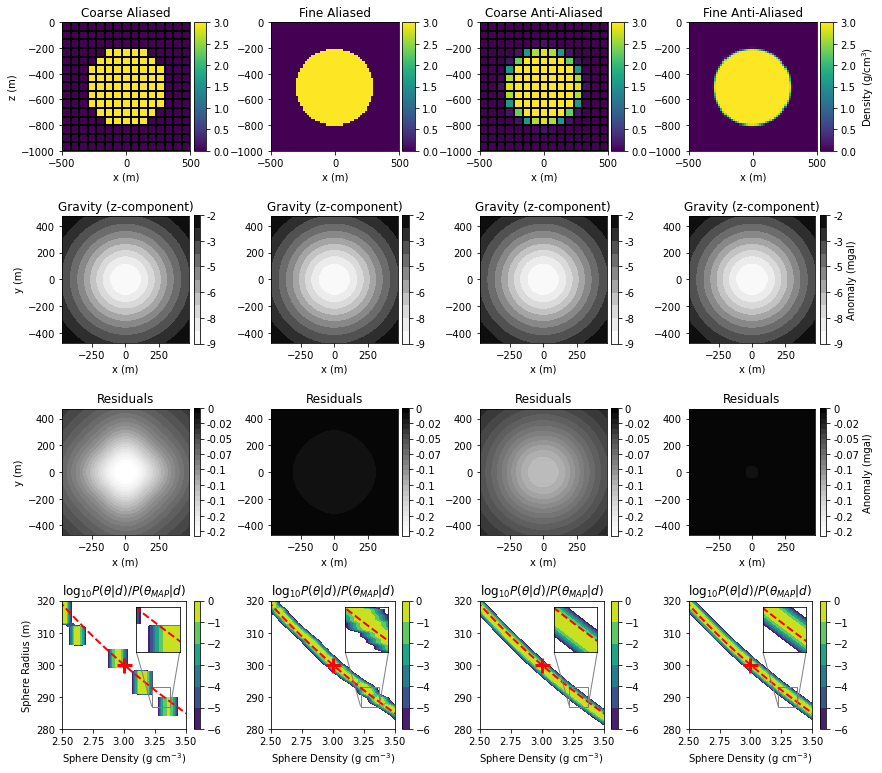

In [6]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition, mark_inset

# Let's make Figure 2 now
history.deserialize([0.0, x0, y0, z0, R_0, rho_0])
fig = plt.figure(figsize=(14,13))
fwdmodels = [fwdmodel, fwdmodel_hires, fwdmodel, fwdmodel_hires]
# fwdmodels = [fwdmodel, fwdmodel, fwdmodel, fwdmodel]
hvals = [0.001*h, 0.001*h/4, h, h/4]
coltitles = ["Coarse Aliased", "Fine Aliased", "Coarse Anti-Aliased", "Fine Anti-Aliased"]
ax_insets = [ ]
for i in range(4):  # loop over columns
    fm, heff = fwdmodels[i], hvals[i]
    model.set_fwdmodel(fm)
    model.h = heff
    profile_timer(fm.calc_gravity, heff)
    # Plot the cross-section
    ax1 = plt.subplot(4, 4, i+1)
    fm.plot_model_slice(ax=ax1, axlabels=(i == 3), grid=(i % 2 == 0))
    ax1.set_title(coltitles[i])
    ax1.set_xlabel("x (m)")
    if i == 0:
        ax1.set_ylabel("z (m)")
    else:
        ax1.set_ylabel("")
    # Plot the gravity signal
    ax2 = plt.subplot(4, 4, i+5)
    contour_opts = { 'cmap': 'Greys' }
    fm.plot_gravity(ax=ax2, axlabels=(i == 3), contour_opts=contour_opts)
    ax2.set_title("Gravity (z-component)")
    ax2.set_xlabel("x (m)")
    if i == 0:
        ax2.set_ylabel("y (m)")
    else:
        ax2.set_ylabel("")
    # Plot the gravity signal
    ax3 = plt.subplot(4, 4, i+9)
    contour_opts.update({ 'vmin': -0.2, 'vmax': 0.0 })
    fm.fwd_data -= data0
    fm.plot_gravity(ax=ax3, axlabels=(i == 3), ncontour=25, contour_opts=contour_opts)
    ax3.set_title("Residuals")
    ax3.set_xlabel("x (m)")
    if i == 0:
        ax3.set_ylabel("y (m)")
    else:
        ax3.set_ylabel("")
    # Plot the posterior for a Gaussian likelihood
    ax4 = plt.subplot(4, 4, i+13)
    model.set_liketype('iiG')
    vet_slice(model, 5, 4, 1.0, 40.0, 30)
    rho_vals = np.linspace(rho_0-1.0, rho_0+1.0, 100)
    R_vals = rho2R(rho_vals)
    plt.plot(rho_vals, R_vals, ls='--', lw=2, color='red')
    plt.plot(rho_0, R_0, marker='+', ms=15, mew=3, color='red')
    plt.title("$\log_{10} P(\\theta|d)/P(\\theta_{{MAP}}|d)$")
    plt.xlabel("Sphere Density (g cm$^{{-3}}$)")
    if i == 0:
        # y-axis plot
        plt.ylabel("Sphere Radius (m)")
    if i in (0, 1, 2, 3,):
        # inset showing terraced behavior
        print("generating inset for {}".format(coltitles[i]))
        # matplotlib 3.3 for inset_axes method
        ax_in = ax4.inset_axes([0.6, 0.6, 0.35, 0.35])
        ax_in.set_xticks([])
        ax_in.set_yticks([])
        origpars = model.history.serialize()
        histpars[5], histpars[4] = 3.3, 290
        model.history.deserialize(histpars)
        vet_slice(model, 5, 4, 0.15, 6.0, 15, ax=ax_in, colorbar=False)
        ax_in.plot(rho_vals, R_vals, ls='--', lw=2, color='red')
        ax_in.plot(rho_0, R_0, marker='+', ms=15, mew=3, color='red')
        model.history.deserialize(origpars)
        mark_inset(ax4, ax_in, loc1=3, loc2=4, fc="none", ec='0.5')
plt.subplots_adjust(hspace=0.5, wspace=0.35)
plt.savefig("fig1.eps")
plt.show()

## Figure 2a:  Setup for anti-aliasing numerical calculation

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

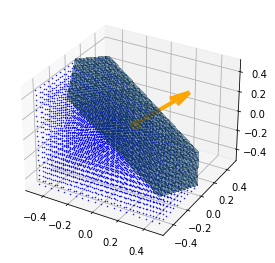

In [7]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# New mesh
mesh_unit = baseline_tensor_mesh(20, 0.05, centering='CCC')
# Set up the surfaces etc.
r0, n = np.array([1, 1, 1])/100.0, np.array([1, 0.5, 1])
n = n/np.sqrt(np.sum(n**2))
rdotn = np.dot(mesh_unit.gridCC - r0, n.T)
# (r-r0).n = 0 = (x-x0)*nx + (y-y0)*ny + (z-z0)*nz --> z = z0 -(x-x0)*nx/nz - (y-y0)*ny/nz
x, y = np.meshgrid(np.arange(-0.475, 0.5, 0.05), np.arange(-0.475, 0.5, 0.05))
z = r0[2] - ((x-r0[0])*n[0] + (y-r0[1])*n[1])/n[2]
# Plot everything
fig = plt.figure(figsize=(6,4.5))
ax = fig.add_subplot(111, projection='3d')
idx = (np.abs(z) < 0.5)
x, y, z = x[idx].ravel(), y[idx].ravel(), z[idx].ravel()
surf = ax.plot_trisurf(x, y, z, # cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.5)
idx = (rdotn < 0.0)
xl, yl, zl = mesh_unit.gridCC[idx].T
ax.plot(xl, yl, zl, c='b', marker='o', ms=0.5, ls='None')
xg, yg, zg = mesh_unit.gridCC[~idx].T
# ax.plot(xg, yg, zg, c='r', marker='o', ms=1, ls='None')
ax.set_zlim(-0.5, 0.5)
qargs = np.concatenate([r0, n]).reshape(6,1,1)
plt.plot([r0[0]], [r0[1]], [r0[2]], marker='o', c='orange', ms=10)
ax.quiver(*qargs, length=0.5, normalize=True, lw=4, color='orange')
plt.savefig("fig2a.eps")
plt.show()